In [240]:
from util import *
from sklearn import metrics
from sklearn.linear_model import SGDClassifier as LogisticRegression

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

NUM_DATA_BATCHES = 100
NUM_ITERS   = 5

The data is for a binary classification task, detecting whether a word token triggers an event in a sentence. The feature vector is from a word2vec model trained with $d=200$.

In [173]:
train_data, train_labels = load('trainingVectors.csv')
test_data, test_labels = load('testVectors.csv')

In [242]:
import sys 

# each batch includes all data up to and including current index.
def load_optimal_batches(data, labels, num_batches):
    batch_size = int(data.shape[0] / num_batches)
    data_batches = []
    label_batches = []
    for i in range(num_batches):
        k = (i + 1) * batch_size
        data_batches.append(data[:k])
        label_batches.append(labels[:k])
    return data_batches, label_batches

# each batch includes only that subset's data.
def load_incremental_batches(data, labels, num_batches):
    batch_size = int(data.shape[0] / num_batches)
    data_batches = []
    label_batches = []
    for i in range(num_batches):
        k = i * batch_size
        data_batches.append(data[k:k+batch_size])
        label_batches.append(labels[k:k+batch_size])
    return data_batches, label_batches

def run(num_runs, reg_param, num_iterations, loader, eta0=LEARNING_RATE, incremental=False, fixed=True, alpha=10.0):
    data_batches, label_batches = loader(train_data, train_labels, NUM_DATA_BATCHES)
    metrics = Metrics(train_labels, test_labels)
    
    sys.stdout.write("Run: ")
    for j in range(num_runs):
        sys.stdout.write(" {},".format(j+1))
        metrics.start_run()
        for i in range(NUM_DATA_BATCHES):
            # load the data for the current batch (either all data up to now or just this instant, depending on loader)
            data = data_batches[i]
            labels = label_batches[i]
            # optionally anneal the learning rate
            if fixed:
                eta = eta0
            else:
                eta = eta0 / (1 + alpha * float(i + 1) / NUM_DATA_BATCHES)
            # train the model
            warm = incremental and i != 0
            
            model = LogisticRegression(loss='log', alpha=reg_param, n_iter=num_iterations, eta0=eta, learning_rate='constant', warm_start=warm)
            model = model.fit(data, labels)
            
            # append predictions for metrics calculations
            train_predictions = model.predict(train_data)
            test_predictions = model.predict(test_data)
            metrics.add_predictions(train_predictions, test_predictions)
        metrics.finish_run()
    return metrics

Get the results over 50 runs:

In [243]:
REG_PARAM   = 0.01
NUM_RUNS_OPTIMAL    = 10
LEARNING_RATE = .005
# calculate results for training over all data up to current iteration as a benchmark
optimal_results = run(NUM_RUNS_OPTIMAL, REG_PARAM, NUM_ITERS, load_optimal_batches, LEARNING_RATE, incremental=False, fixed=True)


Run:  1, 2, 3, 4, 5, 6, 7, 8, 9, 10,

In [244]:
LEARNING_RATE=7.0
REG_PARAM=0.005
FIXED = False
NUM_RUNS=100
incremental_fixed_results = run(NUM_RUNS, REG_PARAM, NUM_ITERS, load_incremental_batches, LEARNING_RATE, incremental=True, fixed=True)
incremental_annealed_results =  run(NUM_RUNS, REG_PARAM, NUM_ITERS, load_incremental_batches, LEARNING_RATE, incremental=True, fixed=False)

Run:  1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100,Run:  1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100,

Now run the incremental version, where each iteration trains only on the current batch. 

Get incremental results over 50 runs:

Populating the interactive namespace from numpy and matplotlib


/home/noah/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


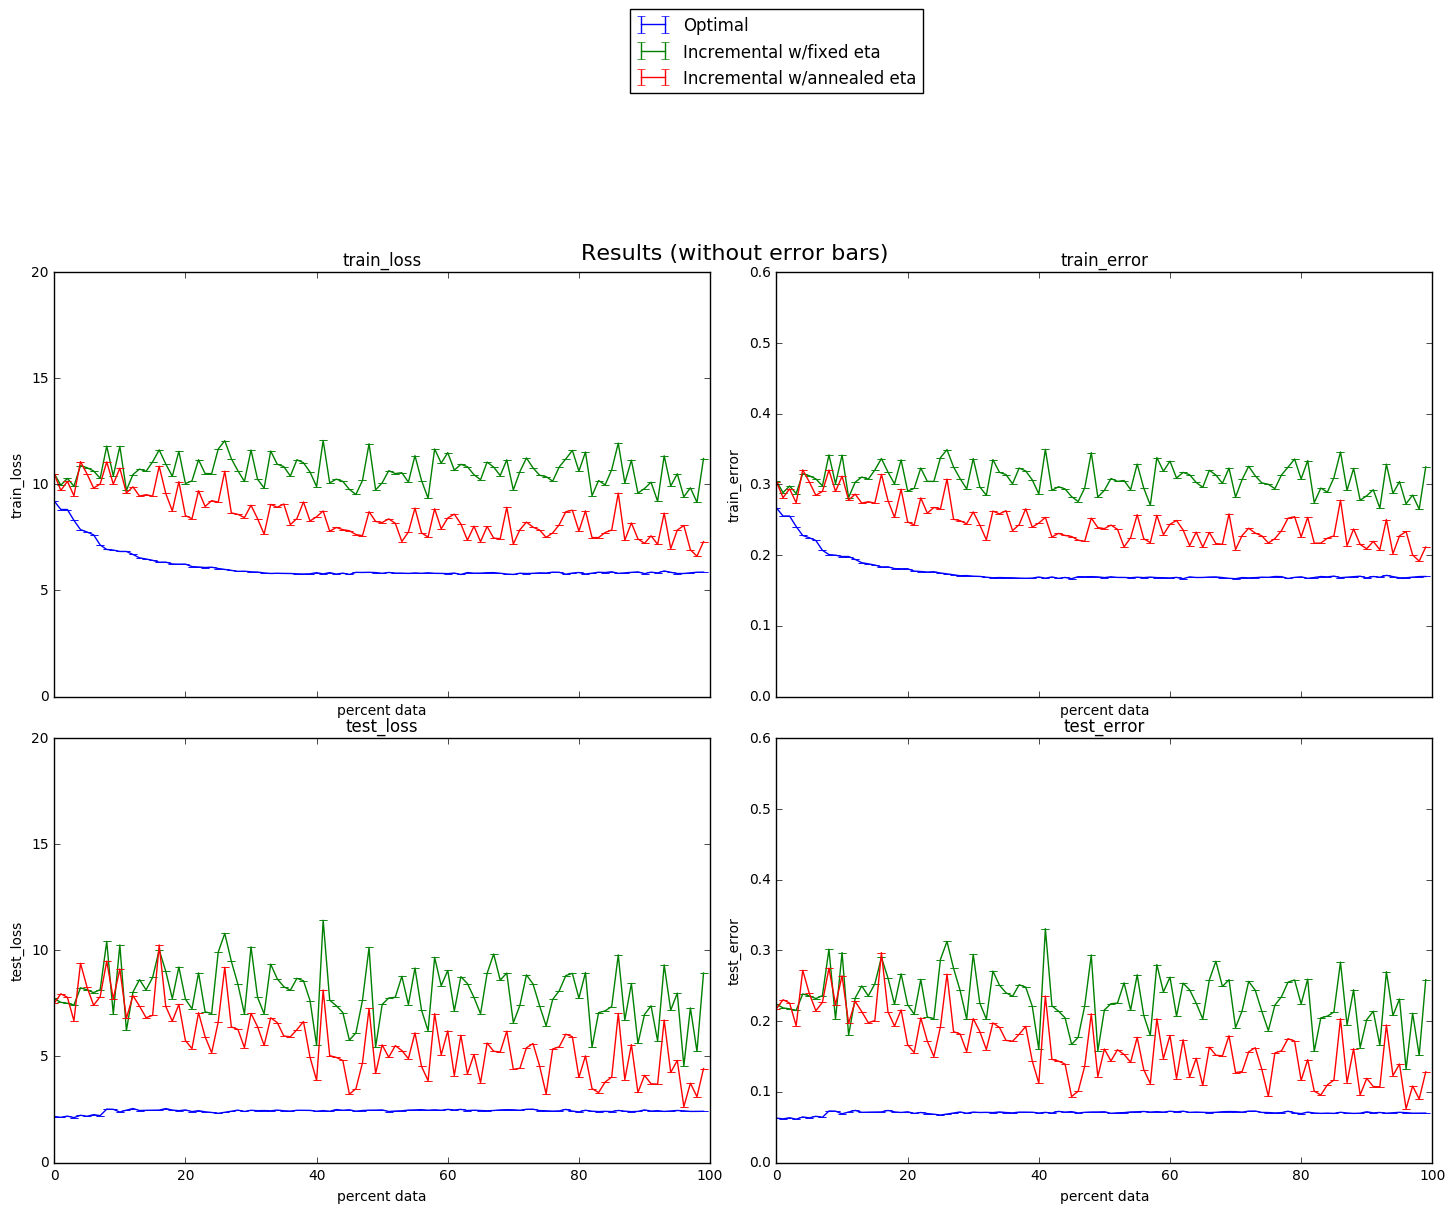

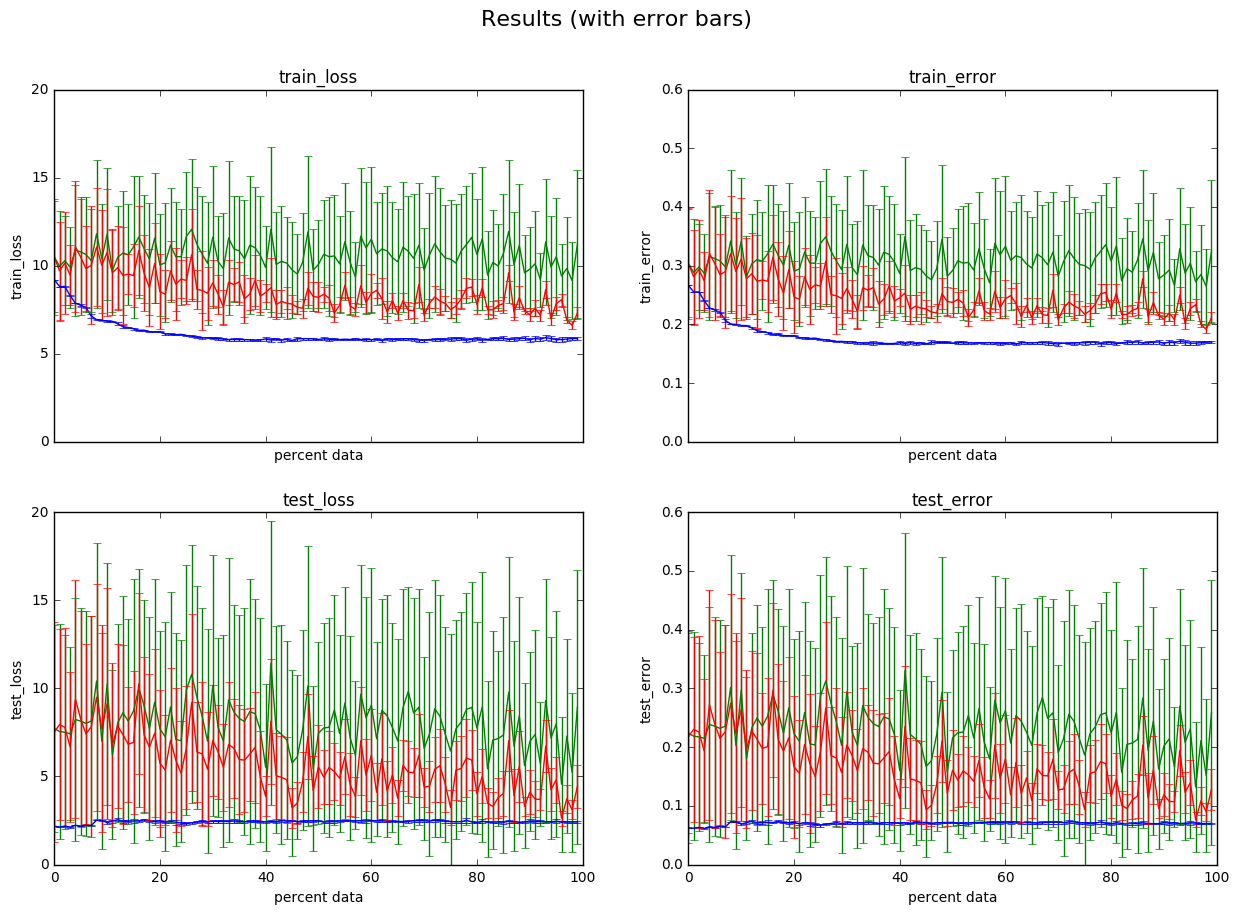

In [262]:
x = list(range(100))

# calculate the means over the different runs
optimal_results.calculate_metrics()
incremental_fixed_results.calculate_metrics()
incremental_annealed_results.calculate_metrics()

%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
plt.tight_layout(pad=3.0, w_pad=2.0, h_pad=2.0)
def plot(ax, metric, show_errors=False):
    optimal_mean, optimal_err = getattr(optimal_results, metric)
    inc_fixed_mean, inc_fixed_err = getattr(incremental_fixed_results, metric)
    inc_annealed_mean, inc_annealed_err = getattr(incremental_annealed_results, metric)
    
    if not show_errors:
        optimal_err = 0
        inc_fixed_err = 0
        inc_annealed_err = 0
    
    ax.errorbar(x, optimal_mean, yerr=optimal_err**2, label="Optimal")
    ax.errorbar(x, inc_fixed_mean, yerr=inc_fixed_err**2, label="Incremental w/fixed eta")
    ax.errorbar(x, inc_annealed_mean, yerr=inc_annealed_err**2, label="Incremental w/annealed eta")
    
    ax.set_xlabel("percent data")
    ax.set_ylabel(metric[:-5])
    
    ax.set_title(metric[:-5])
    
plot(axs[0,0], 'train_loss_data')
plot(axs[0,1], 'train_error_data')
plot(axs[1,0], 'test_loss_data')
plot(axs[1,1], 'test_error_data')

# set the same bounds
axs[0,1].set_ylim([0,0.6])
axs[1,1].set_ylim([0,0.6])
axs[1,0].set_ylim([0,20])
axs[0,0].set_ylim([0,20])
                   


plt.legend(loc='lower center', bbox_to_anchor=(0, 2.5))
fig.suptitle('Results (without error bars)', fontsize=16)

fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)

plot(axs[0,0], 'train_loss_data', show_errors=True)
plot(axs[0,1], 'train_error_data', show_errors=True)
plot(axs[1,0], 'test_loss_data', show_errors=True)
plot(axs[1,1], 'test_error_data', show_errors=True)

# set the same bounds
axs[0,1].set_ylim([0,0.6])
axs[1,1].set_ylim([0,0.6])
axs[1,0].set_ylim([0,20])
axs[0,0].set_ylim([0,20])
                   

fig.suptitle("Results (with error bars)", fontsize=16)

plt.show()

The "optimal" scenario trains the classifier at iteration $i$ on all data up to iteration $i$. The incremental scenario incorporates only the data at batch $i$.

In the incremental scenario, I either use a fixed learning rate eta or a learning rate that is annealed based on how many batches of data the classifier has seen. The annealing factor is $\eta(t) = \dfrac{\eta_0}{1 + \alpha \dfrac{t}{\tau}}$, where $\alpha$ is a scaling factor and $\tau$ is the total number of timesteps (data batches).

I evaluated error and log-loss for the training and test data. In the optimal scenario I ran 10 trials since the variance is low to begin with, and for the incremental setups I ran 100 trials.


On train data, the constant learning rate incremental algorithm does not converge towards the optimal, while the annealed learning rate version does. The results for test data are similar, but the loss/error seem to descend more quickly with higher variance. In both cases the variance of the result lowers significantly as the percent data covered increases.


By the end, the optimal test error is about $0.08$, the incremental test error for an annealed eta is $.14$, and the incremental test error for fixed eta is $.27$.

In [271]:
%time run(1, REG_PARAM, NUM_ITERS, load_optimal_batches, LEARNING_RATE, incremental=False, fixed=True)


Run:  1,CPU times: user 9.93 s, sys: 27.3 s, total: 37.3 s
Wall time: 5.24 s


In [272]:
%time run(1, REG_PARAM, NUM_ITERS, load_incremental_batches, LEARNING_RATE, incremental=True, fixed=True)

Run:  1,CPU times: user 3.28 s, sys: 7.99 s, total: 11.3 s
Wall time: 1.47 s
